In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop

import h5py
import datetime
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
%matplotlib inline


In [2]:
import tensorflow as tf

# Check if CUDA is available
if tf.test.is_built_with_cuda():
    print("CUDA is available")
    # Enable GPU memory growth (optional)
    physical_devices = tf.config.list_physical_devices('GPU')
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, False)
else:
    print("CUDA is not available")

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

CUDA is available
TensorFlow version: 2.10.0


In [3]:
picture_size = 224
folder_path = r"E:/project/FER/"

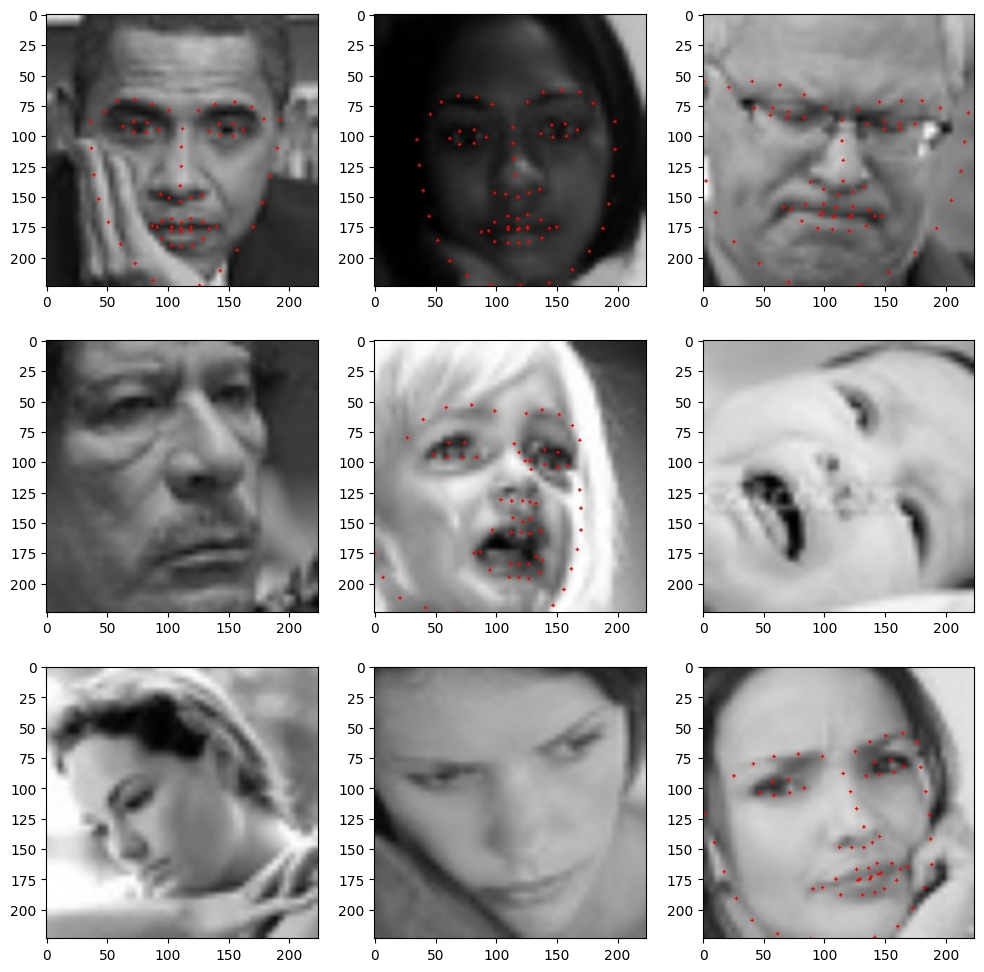

In [4]:
expression = 'sad'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"landmarked_train/"+expression+"/"+
                  os.listdir(folder_path + "landmarked_train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)   
plt.show()

In [5]:
BATCH_SIZE  = 32

datagen_train  = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(folder_path+"landmarked_train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "rgb",
                                              batch_size=BATCH_SIZE,
                                              class_mode='sparse',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path+"Resized_validation",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "rgb",
                                              batch_size=BATCH_SIZE,
                                              class_mode='sparse',
                                              shuffle=False)



Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [6]:
from sklearn.utils.class_weight import compute_class_weight

# Get the class labels from the train_set
class_labels = train_set.classes
print("train_set.classes content:", train_set.classes)

# Pass the list as the positional argument
class_weights = compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)

# Convert class weights to dictionary format
class_weights_dict = dict(enumerate(class_weights))



train_set.classes content: [0 0 0 ... 6 6 6]


In [7]:
print(np.unique(class_labels))

[0 1 2 3 4 5 6]


NEW MODEL

In [8]:
import h5py
import datetime
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
%matplotlib inline

In [9]:
num_class = 7

TRAIN_EPOCH = 30
TRAIN_LR = 1e-3
TRAIN_ES_PATIENCE = 5
TRAIN_LR_PATIENCE = 3
TRAIN_MIN_LR = 1e-6
TRAIN_DROPOUT = 0.1

FT_EPOCH = 50
FT_LR = 1e-5
FT_LR_DECAY_STEP = 80.0
FT_LR_DECAY_RATE = 1
FT_ES_PATIENCE = 20
FT_DROPOUT = 0.2

ES_LR_MIN_DELTA = 0.003

In [25]:
# Model Building
input_layer = tf.keras.Input(shape=(224,224,3), name='universal_input')
# sample_resizing = tf.keras.layers.experimental.preprocessing.Resizing(224, 224, name="resize")
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip(mode='horizontal'), 
                                        tf.keras.layers.RandomContrast(factor=0.3)], name="augmentation")
preprocess_input = tf.keras.applications.mobilenet.preprocess_input

backbone = tf.keras.applications.mobilenet.MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
backbone.trainable = False
base_model = tf.keras.Model(backbone.input, backbone.layers[-29].output, name='base_model')

self_attention = tf.keras.layers.Attention(use_scale=True, name='attention')
patch_extraction = tf.keras.Sequential([
    tf.keras.layers.SeparableConv2D(256, kernel_size=4, strides=4, padding='same', activation='relu'), 
    tf.keras.layers.SeparableConv2D(256, kernel_size=2, strides=2, padding='valid', activation='relu'), 
    tf.keras.layers.Conv2D(256, kernel_size=1, strides=1, padding='valid', activation='relu')
], name='patch_extraction')
global_average_layer = tf.keras.layers.GlobalAveragePooling2D(name='gap')
pre_classification = tf.keras.Sequential([tf.keras.layers.Dense(32, activation='relu'), 
                                          tf.keras.layers.BatchNormalization()], name='pre_classification')
prediction_layer = tf.keras.layers.Dense(num_class, activation="softmax", name='classification_head')

inputs = input_layer
# x = sample_resizing(inputs)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = patch_extraction(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(TRAIN_DROPOUT)(x)
x = pre_classification(x)
x = self_attention([x, x])
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs, name='train-head')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=TRAIN_LR, global_clipnorm=3.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training Procedure
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=TRAIN_ES_PATIENCE, min_delta=ES_LR_MIN_DELTA, restore_best_weights=True)
learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=TRAIN_LR_PATIENCE, verbose=0, min_delta=ES_LR_MIN_DELTA, min_lr=TRAIN_MIN_LR)
history = model.fit(train_set, epochs=TRAIN_EPOCH, steps_per_epoch=train_set.n // BATCH_SIZE, 
                    validation_data=test_set, validation_steps=test_set.n // BATCH_SIZE,
                    class_weight=class_weights_dict, callbacks=[early_stopping_callback, learning_rate_callback])




Model: "train-head"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 universal_input (InputLayer)   [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 augmentation (Sequential)      (None, 224, 224, 3)  0           ['universal_input[0][0]']        
                                                                                                  
 tf.math.truediv_1 (TFOpLambda)  (None, 224, 224, 3)  0          ['augmentation[0][0]']           
                                                                                                  
 tf.math.subtract_1 (TFOpLambda  (None, 224, 224, 3)  0          ['tf.math.truediv_1[0][0

In [42]:
# Evaluate the model on the test set
evaluation_results = model.evaluate(test_set)

# Extract the test accuracy from the evaluation results
test_accuracy = evaluation_results[1]  # Assuming accuracy is the second element in the evaluation results

# Print the test accuracy
print("Test Accuracy:", test_accuracy*100.0)


225/225 [==============================] - 10s 43ms/step - loss: 0.6716 - accuracy: 0.7796
Test Accuracy: 77.96043753623962


In [26]:
from tensorflow.keras.models import model_from_json

# Assume 'model' is your compiled Keras model

# Save the model architecture to JSON format
model_json = model.to_json()

# Write the model architecture to a JSON file
with open("k2_model.json", "w") as json_file:
    json_file.write(model_json)

# Optionally, you can also save the model weights
model.save_weights("k2_model_weights.weights.h5")

In [10]:
from tensorflow.keras.models import model_from_json
loaded_model = model_from_json(open("k2_model.json", "r").read())
loaded_model.load_weights('k2_model_weights.weights.h5')

In [11]:
# Loading Har-Cascade for Face Detection

import cv2
face_haar_cascade = cv2.CascadeClassifier(r'C:\Users\ayanc\Downloads\haarcascade_frontalface_default')


In [12]:
EMOTIONS = ["angry","disgust","fear", "happy", "neutral", "sad", "surprise"]

In [13]:
import cv2
import numpy as np
import dlib

# Load the Haar cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# Load the facial landmark predictor
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')


# Function to detect faces and emotions
def detect_faces_emotions(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(10, 10))
    
    for (x, y, w, h) in faces:
        EMOTIONS = ["angry","disgust","fear", "happy", "neutral", "sad", "surprise"]
        
        # Draw rectangle around the face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
        # Convert rectangle to dlib's rectangle format
        dlib_rect = dlib.rectangle(x, y, x+w, y+h)
        
        # Predict facial landmarks
        landmarks = predictor(gray, dlib_rect)
        
        # Draw facial landmarks (shapes)
        for i in range(68):  # Assuming 68 landmarks
            cv2.circle(frame, (landmarks.part(i).x, landmarks.part(i).y), 1, (0, 255, 0), -1)
        
        # Resize the ROI to match the input size of the emotion detection model
        roi_gray = gray[y:y+h, x:x+w]
        roi_gray_resized = cv2.resize(roi_gray, (48, 48))
        roi_gray_resized = cv2.resize(roi_gray_resized, (224, 224))

        # Ensure the image is in uint8 format
        roi_gray_resized = roi_gray_resized.astype('uint8')

        
        # Convert grayscale image to RGB format
        roi_gray_resized_rgb = cv2.cvtColor(roi_gray_resized, cv2.COLOR_GRAY2BGR)
        
        
        # Convert the RGB image to array format
        roi_gray_resized_array = img_to_array(roi_gray_resized_rgb)

        # Expand the dimensions to match the input shape expected by the model
        roi_gray_resized_array = np.expand_dims(roi_gray_resized_array, axis=0)
        
        # Predict emotions
        emotions = loaded_model.predict(roi_gray_resized_array)[0]
        emotion_label = EMOTIONS[np.argmax(emotions)]
        confidence_scores = {emotion: score for emotion, score in zip(EMOTIONS, emotions)}
        
        # Display the emotion label and confidence metrics on the frame
        cv2.putText(frame, f"{emotion_label} ({confidence_scores[emotion_label]*100:.2f}%)", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    return frame

# Main loop for capturing video and detecting faces/emotions
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret:
        break
    
    frame = detect_faces_emotions(frame)
    
    cv2.imshow('Face Emotion Detection', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 28ms/step


# Plotting Accuracy & Loss

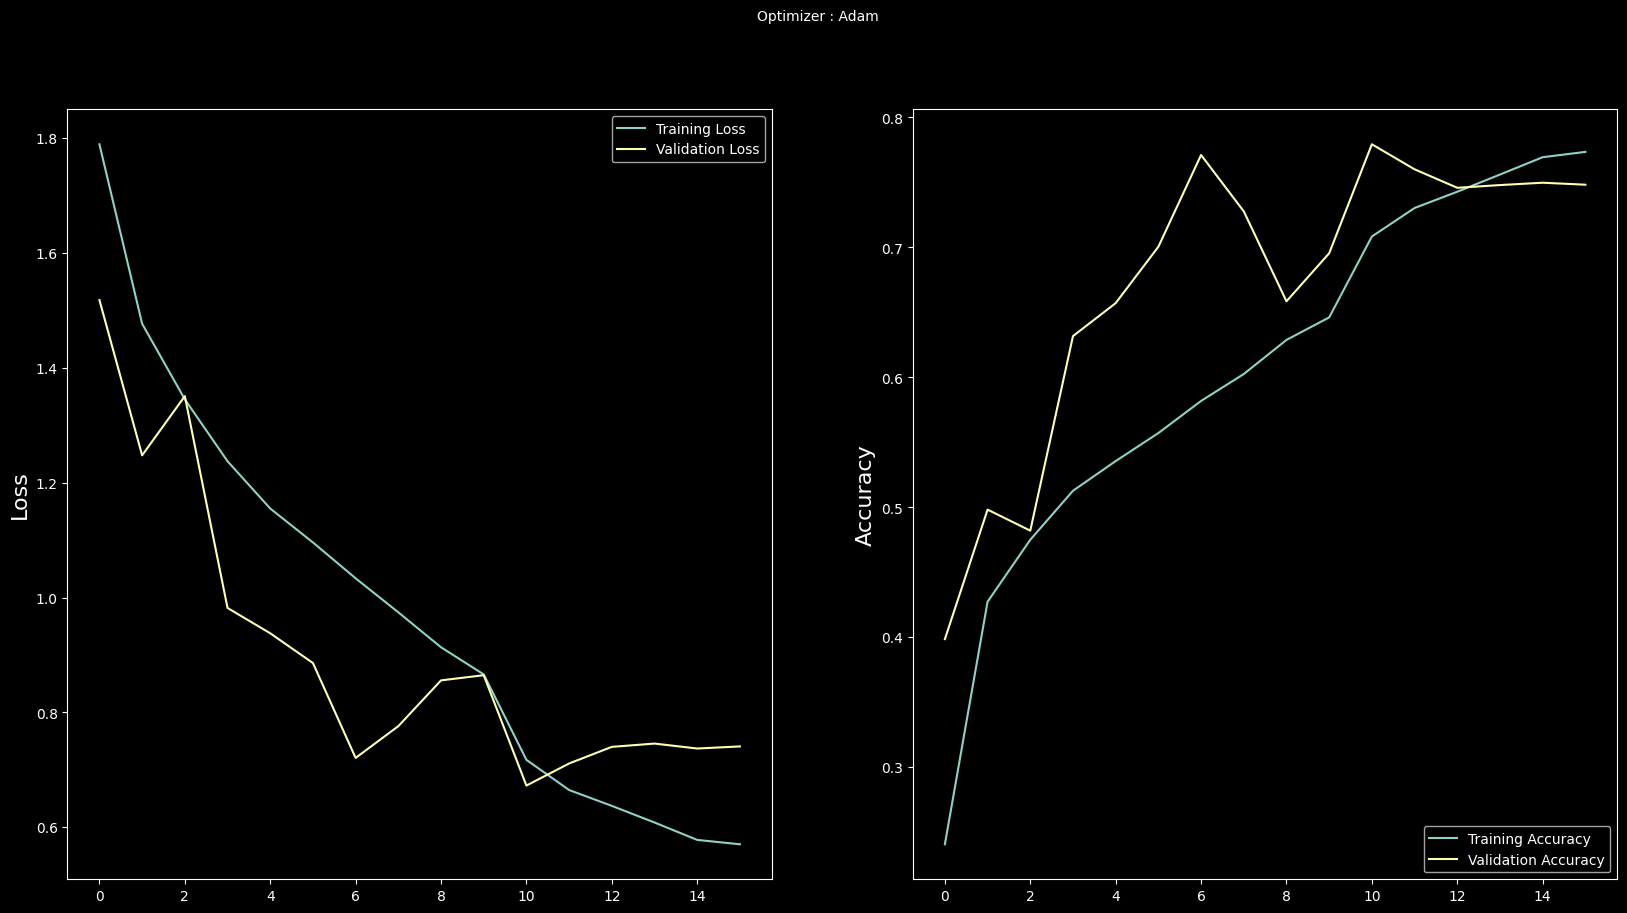

In [27]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Step 1: Use the trained model to predict labels for the validation set
predicted_labels = loaded_model.predict_generator(test_set)

# Step 2: Convert predicted labels from one-hot encoded format to class indices
predicted_indices = np.argmax(predicted_labels, axis=1)

# Step 3: Get the true class indices from the validation set
true_indices = test_set.classes

# Step 4: Compute the confusion matrix
conf_matrix = confusion_matrix(true_indices, predicted_indices)

# Step 5: Print or visualize the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


C:\Users\ayanc\AppData\Local\Temp\ipykernel_22136\811157171.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicted_labels = loaded_model.predict_generator(test_set)


Confusion Matrix:
[[ 786    4   43    8   33   75    9]
 [  41   67    1    0    0    1    1]
 [ 117    4  536    9   46  222   90]
 [  34    1   14 1637   30   36   22]
 [  59    2   34   23  956  141   18]
 [ 126    4   66   13  172  857    9]
 [  10    0   47    4   12    1  757]]


225/225 [==============================] - 9s 40ms/step


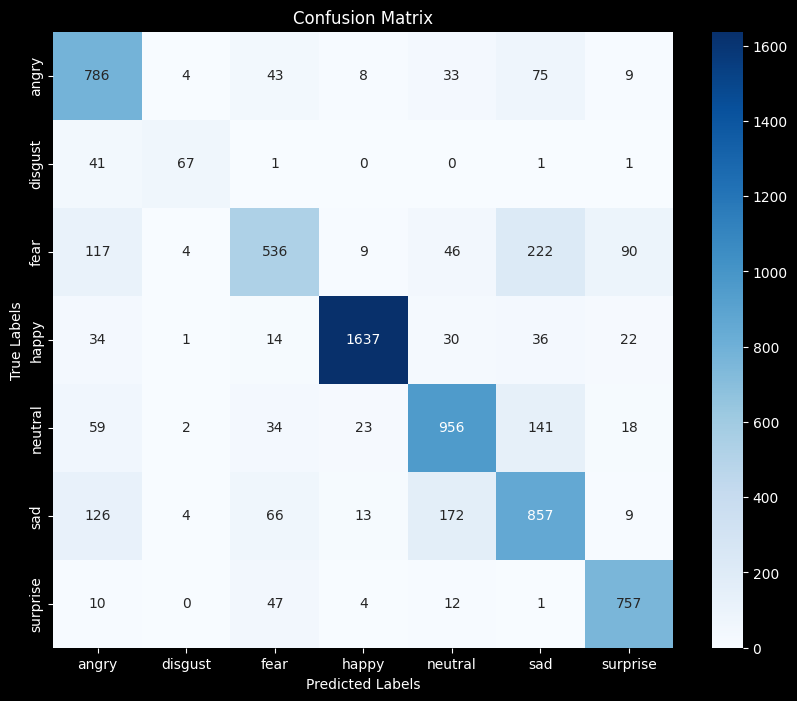

In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test dataset
y_pred = loaded_model.predict(test_set)
y_pred_classes = np.argmax(y_pred, axis=1)

# Extract true labels
true_classes = test_set.classes

# Get class labels
class_labels = list(test_set.class_indices.keys())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [21]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_classes, y_pred_classes, average=None)

# Create a DataFrame to store precision, recall, and F1 score values
metrics_df = pd.DataFrame({'Emotion': class_labels,
                           'Precision': precision,
                           'Recall': recall,
                           'F1 Score': f1_score})

# Print the DataFrame
print(metrics_df)


    Emotion  Precision    Recall  F1 Score
0     angry   0.670077  0.820459  0.737682
1   disgust   0.817073  0.603604  0.694301
2      fear   0.723347  0.523438  0.607365
3     happy   0.966352  0.922773  0.944060
4   neutral   0.765412  0.775345  0.770346
5       sad   0.642911  0.687249  0.664341
6  surprise   0.835541  0.910951  0.871618
